**Author**: Chertova Nataliya

**Date**: 05.06.2025

---

## Part 1. Hypothesis Testing in Python and Analytical Report Preparation

We preprocessed the data in SQL, and now it's ready for hypothesis testing in Python. Let's load user data from Moscow and St. Petersburg with their total activity hours from the `yandex_knigi_data.csv` file.

We will **check for duplicate** user IDs. We'll **compare group sizes**, their statistics, and distribution.

Let's test the hypothesis: **users from St. Petersburg spend, on average, more time reading and listening to books in the application than users from Moscow.** We will prove this statistically using a one-sided hypothesis test with two samples:

* **Null Hypothesis** $H_0: \mu_{SPb} \le \mu_{Moscow}$
    The average activity time of users in St. Petersburg is not greater than in Moscow.
* **Alternative Hypothesis** $H_1: \mu_{SPb} > \mu_{Moscow}$
    The average activity time of users in St. Petersburg is greater, and this difference is statistically significant.

Based on the data analysis results, we will **prepare an analytical report** including:

* The chosen t-test type and statistical significance level.
* Test result, or p-value.
* Conclusion based on the obtained p-value, i.e., interpretation of the results.
* One or two possible reasons explaining the obtained results.

---

### Project Goals and Objectives

The **project's goal** is to analyze data received from the Yandex Books service and test the hypothesis that users who bring higher LTV are more loyal, and therefore, spend, on average, more time reading and listening to books in the application.

The **project objectives** include:

* downloading and evaluating the provided data
* statistically testing the hypothesis that users who bring higher LTV are more loyal, and therefore, spend, on average, more time reading and listening to books in the application
* writing an analytical report with the analysis results

---

### Data Description

The source data is presented in the `yandex_knigi_data.csv` table, containing the following fields:

* `Unnamed: 0` - row index
* `city` - user's city
* `puid` - individual user ID
* `hours` - total listening hours per user

---

### Project Content

Below are the main project steps:

1.  **Data extraction and preprocessing in SQL.**
2.  **Loading data** for hypothesis testing in Python.
3.  **Checking for duplicate** user IDs.
4.  **Comparing group sizes**, their statistics, and distribution.
5.  **Performing statistical analysis** and hypothesis testing: users from St. Petersburg spend, on average, more time reading and listening to books in the application than users from Moscow.
6.  **Preparing an analytical report** based on the data analysis results.

---

## 1. Loading and Exploring Data

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats import f_oneway
import seaborn as sns

In [51]:
# display the dataframe with the data
df = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')
df.head(5)

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [52]:
 duplicates = df[df.duplicated(subset=['puid'], keep=False)].sort_values(by='puid')
display(duplicates.head(10))
print(f"Number of duplicates in column 'puid': {duplicates.shape[0]}")

,Unnamed: 0,city,puid,hours
35,35,Москва,2637041,10.317371
6247,6247,Санкт-Петербург,2637041,3.883926
134,134,Москва,9979490,32.415573
6274,6274,Санкт-Петербург,9979490,1.302997
145,145,Москва,10597984,42.931506
6279,6279,Санкт-Петербург,10597984,9.041320
150,150,Москва,10815097,9.086655
6283,6283,Санкт-Петербург,10815097,0.323291
187,187,Москва,13626259,21.104167
6300,6300,Санкт-Петербург,13626259,1.648434


Number of duplicates in column 'puid': 488


Thus, the data contains 488 rows with duplicate users, predominantly belonging to both groups - Moscow and St. Petersburg.
To ensure data independence, we will remove these users from both groups, as keeping them in either group would be incorrect from the perspective of sample independence.

In [53]:
df_original = df 
print(f"Number of rows before deletion: {df_original.shape[0]}")
df = df.drop_duplicates(subset=['puid'], keep=False)
print(f"Number of rows after deletion: {df.shape[0]}")

Number of rows before deletion: 8784
Number of rows after deletion: 8296


In [54]:
# сompare the sizes of the groups (users from different cities)
group_sizes = df.groupby('city')['puid'].nunique().sort_values(ascending=False)

group_sizes

city
Москва             5990
Санкт-Петербург    2306
Name: puid, dtype: int64

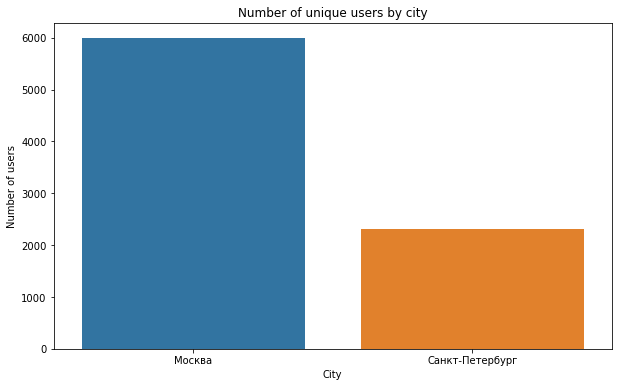

In [57]:
# Visualization of group sizes
plt.figure(figsize=(10, 6))
sns.barplot(x=group_sizes.index, y=group_sizes.values)
plt.title('Number of unique users by city')
plt.xlabel('City')
plt.ylabel('Number of users')
plt.show()

The group of users from Moscow has 2.5 times more users than the group of users from St. Petersburg.

In [58]:
# Statistics of listening hours by group
group_stats = df.groupby('city')['hours'].describe()

group_stats

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
Москва,5990.0,10.848192,36.925622,0.000022,0.057042,0.888232,5.933439,857.209373
Санкт-Петербург,2306.0,11.264433,39.831755,0.000025,0.060173,0.875355,6.138424,978.764775


Statistics by group show quite similar data:
- The average listening hours are 11 - (10.8 hours for users from Moscow and 11.3 for users from St. Petersburg);
- The standard deviation is also quite close - 36.9 for Moscow and 39.8 for St. Petersburg.

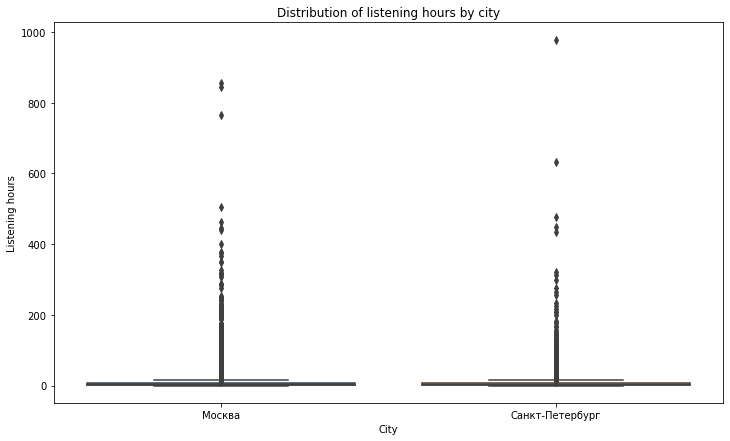

In [59]:
# Distribution of listening hours
plt.figure(figsize=(12, 7))
sns.boxplot(x='city', y='hours', data=df)
plt.title('Distribution of listening hours by city')
plt.xlabel('City')
plt.ylabel('Listening hours')
plt.show()

Strong outliers are observed on the plot; let's display only the main part of the data.

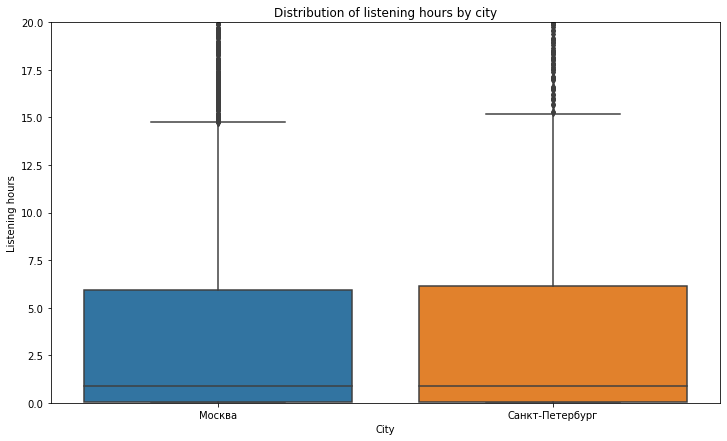

In [60]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='city', y='hours', data=df)
plt.title('Distribution of listening hours by city')
plt.xlabel('City')
plt.ylabel('Listening hours')
plt.ylim(0, 20)
plt.show()


---

**CONCLUSION:**

The difference in the number of participants in the groups is quite noticeable and could impact the study, as Student's T-test requires homogeneity of variances between groups. For this reason, an assessment of the equality of variances in the groups will be conducted next.

A large standard deviation and the presence of significant outliers can skew the mean value for the entire group, making it difficult to detect statistically significant differences, even if they exist for most users.

It would be possible to exclude outliers from the analysis, but in this case, it seems that this is not the best strategy, as we are investigating user loyalty, and each obtained value, including those significantly deviating from the mean, may indicate important behavioral differences within the groups.

---

## 2. Hypothesis Testing in Python

The hypothesis is as follows: users from St. Petersburg spend, on average, more time reading and listening to books in the application than users from Moscow. Try to statistically prove this using a one-sided hypothesis test with two samples:

- Null Hypothesis H₀: The average user activity in hours in the two groups (Moscow and St. Petersburg) does not differ.

- Alternative Hypothesis H₁: The average user activity in St. Petersburg is greater, and this difference is statistically significant.

In [61]:
# Let's assess the independence of the groups
A = df[df['city'] == 'Москва']['puid']
B = df[df['city'] == 'Санкт-Петербург']['puid']
intersection = list(set(A) & set(B))
len(intersection)

0

In [63]:
# Сalculate the variance by groups
variance_by_city = df.groupby('city')['hours'].var()

print("\nVariance of activity (in hours) by city:")
print(variance_by_city)


Variance of activity (in hours) by city:
city
Москва             1363.501557
Санкт-Петербург    1586.568674
Name: hours, dtype: float64


In [64]:
# Check for equality of sample variances

# Target metric
metric_a = df[df.city=='Москва']['hours'] ## sample of the target metric for group A
metric_b = df[df.city=='Санкт-Петербург']['hours'] ## sample of the target metric for group B

# Choose standard significance level
alpha = 0.05 

# Perform Fisher's F-test to determine equality of variances
stat_f_test, p_value_stat_f_test = f_oneway(metric_a, metric_b)
if p_value_stat_f_test > alpha:
    print(f'p-value of F-test = {round(p_value_stat_f_test, 2)}')
    print('The null hypothesis is confirmed! Variances in groups A and B are equal.')
    print('Student\'s t-test should be used.')
else:
    print(f'p-value of Welch\'s test = {round(p_value_stat_f_test, 2)}')
    print('The null hypothesis is not confirmed! Mean variances in groups A and B are not equal.')
    print('Welch\'s test should be used.')

p-value of F-test = 0.65
The null hypothesis is confirmed! Variances in groups A and B are equal.
Student's t-test should be used.


In [65]:
# As per the task conditions:
# Null Hypothesis H0: μSPb ≤ μMoscow
# Alternative Hypothesis H1: μSPb > μMoscow

# Let's perform a T-test to estimate the difference in sample means
stat_ttest, p_value_ttest = ttest_ind(
    metric_a, 
    metric_b, 
    alternative='less' 
)
if p_value_ttest > alpha:
    print(f'p-value of Student\'s t-test = {round(p_value_ttest, 2)}')
    print('The null hypothesis is confirmed! The sample means in groups A and B are equal.')
    print('Interpretation: The average user activity in hours in the two groups (Moscow and St. Petersburg) does not differ.')
else:
    print(f'p-value of Student\'s t-test = {round(p_value_ttest, 2)}')
    print('The null hypothesis is not confirmed! The sample means in groups A and B are not equal, and group B has a larger mean.')
    print('Interpretation: The average user activity in St. Petersburg is greater, and this difference is statistically significant.')

p-value of Student's t-test = 0.33
The null hypothesis is confirmed! The sample means in groups A and B are equal.
Interpretation: The average user activity in hours in the two groups (Moscow and St. Petersburg) does not differ.


---

## 3. Analytical Report

For the analysis, Student's t-test was chosen as it's optimal for the task conditions: two samples that meet the required criteria:
* **Normality of the sample mean** – due to a sufficient amount of data.
* **Independence of observations** – ensured by excluding overlapping users.
* **Equality of sample variances** – confirmed by Fisher's F-test.

A significance level of 5% was adopted for hypothesis testing, which is a standard value for this type of test.

The obtained **p-value was 0.33**. This indicator suggests that we don't have enough evidence to claim that the average user activity in hours in the two groups (Moscow and St. Petersburg) differs statistically significantly.

This result can be explained by the following:
* **There truly is no difference between the groups.** In this case, users from St. Petersburg spend, on average, the same amount of time reading and listening to books in the app as users from Moscow. Therefore, if there's no difference in activity between cities, then some other factor influences LTV.
* **There is a difference between the groups, but we couldn't detect it due to insufficient test power (Type II error).**